In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import matplotlib as mpl
import seaborn as sns
import os
import io
from PIL import Image
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from scipy.fftpack import dct, idct

plt.style.use(["science", "grid"])
OUTPUT_FOLDER = os.path.join("plots")
FONT_SIZE = 12
plt.rcParams.update({
    'font.size': FONT_SIZE,          # Set font size for labels, titles, and ticks
    'axes.labelsize': FONT_SIZE,      # Axis label font size
    'xtick.labelsize': FONT_SIZE,     # X-axis tick label font size
    'ytick.labelsize': FONT_SIZE      # Y-axis tick label font size
})

def save_fig(name):
    plt.savefig(os.path.join(OUTPUT_FOLDER, name+".pdf"), dpi=300)

FILE_PATH = "facultad.png"

In [2]:
# Cargar imagen y convertir a RGB
img_bgr = cv2.imread(FILE_PATH)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Separación componentes RGB
r, g, b = cv2.split(img_rgb)

# Conversión a YCrCb
img_ycc = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCrCb)
y, cr, cb = cv2.split(img_ycc)

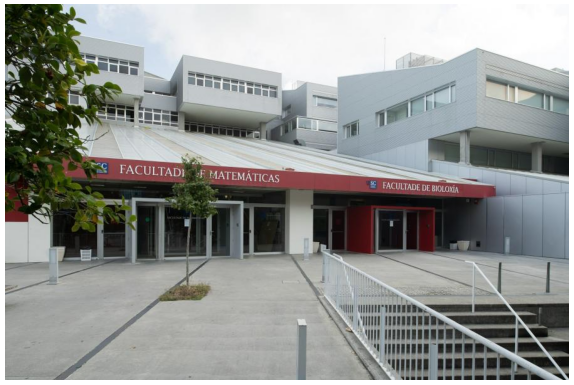

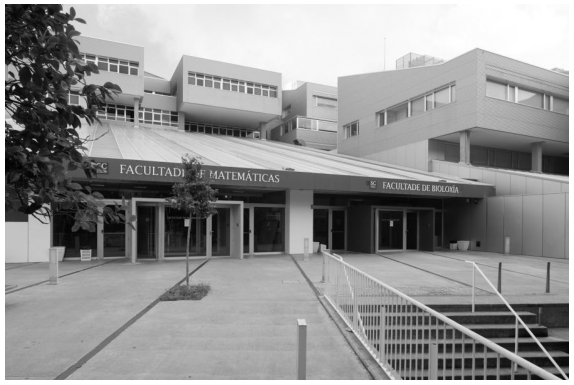

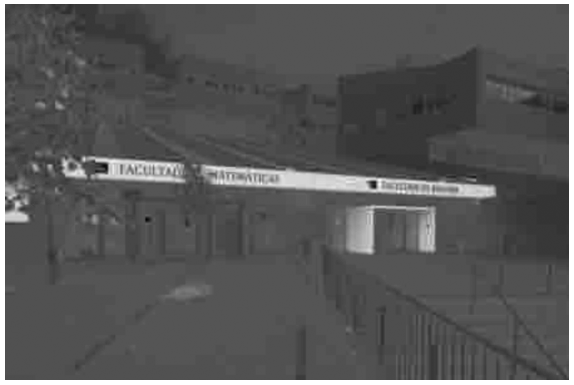

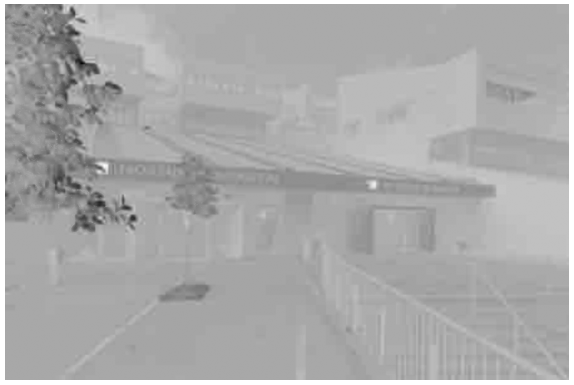

<Figure size 350x262.5 with 0 Axes>

In [3]:
plt.figure(figsize=(6, 10))
plt.imshow(img_rgb)
plt.grid(False)
plt.axis("off")
plt.tight_layout()
save_fig("original")
plt.show()

plt.figure(figsize=(6, 10))
plt.imshow(y, cmap="gray")
plt.grid(False)
plt.axis("off")
plt.tight_layout()
save_fig("y_channel")
plt.show()

plt.figure(figsize=(6, 10))
plt.imshow(cr, cmap="gray")
plt.grid(False)
plt.axis("off")
plt.tight_layout()
save_fig("cr_channel")
plt.show()

plt.figure(figsize=(6, 10))
plt.imshow(cb, cmap="gray")
plt.grid(False)
plt.axis("off")
plt.tight_layout()
save_fig("cb_channel")
plt.show()

plt.tight_layout()
plt.show()

In [4]:
# Función auxiliar para extraer un bloque de una imagen
# canales: 0=Y, 1=Cb, 2=Cr
def get_block(img_ycc, channel, i, j):
    return img_ycc[(i*8):((i+1)*8), (j*8):((j+1)*8), channel].astype(np.int16)

# Función para aplicar la DCT 2-dimensional a partir de la dct de scipy
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

# Transformada inversa de dct2
def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

# Función auxiliar para cuantizar un bloque a partir de una tabla
def quantize_block(dct_block, quant_table):
    return np.round(dct_block / quant_table)

# Funciones auxiliar para desarrollar un bloque mediante orden zigzag y obtener sus índices
def zigzag_indices(n=8):
    indices = [[] for _ in range(2*n - 1)]
    for i in range(n):
        for j in range(n):
            indices[i+j].append((j,i) if (i+j)%2 == 0 else (i,j))
    return [item for sub in indices for item in sub]

def zigzag_block(block):
    idx = zigzag_indices(len(block))
    return np.array([block[i, j] for i, j in idx])

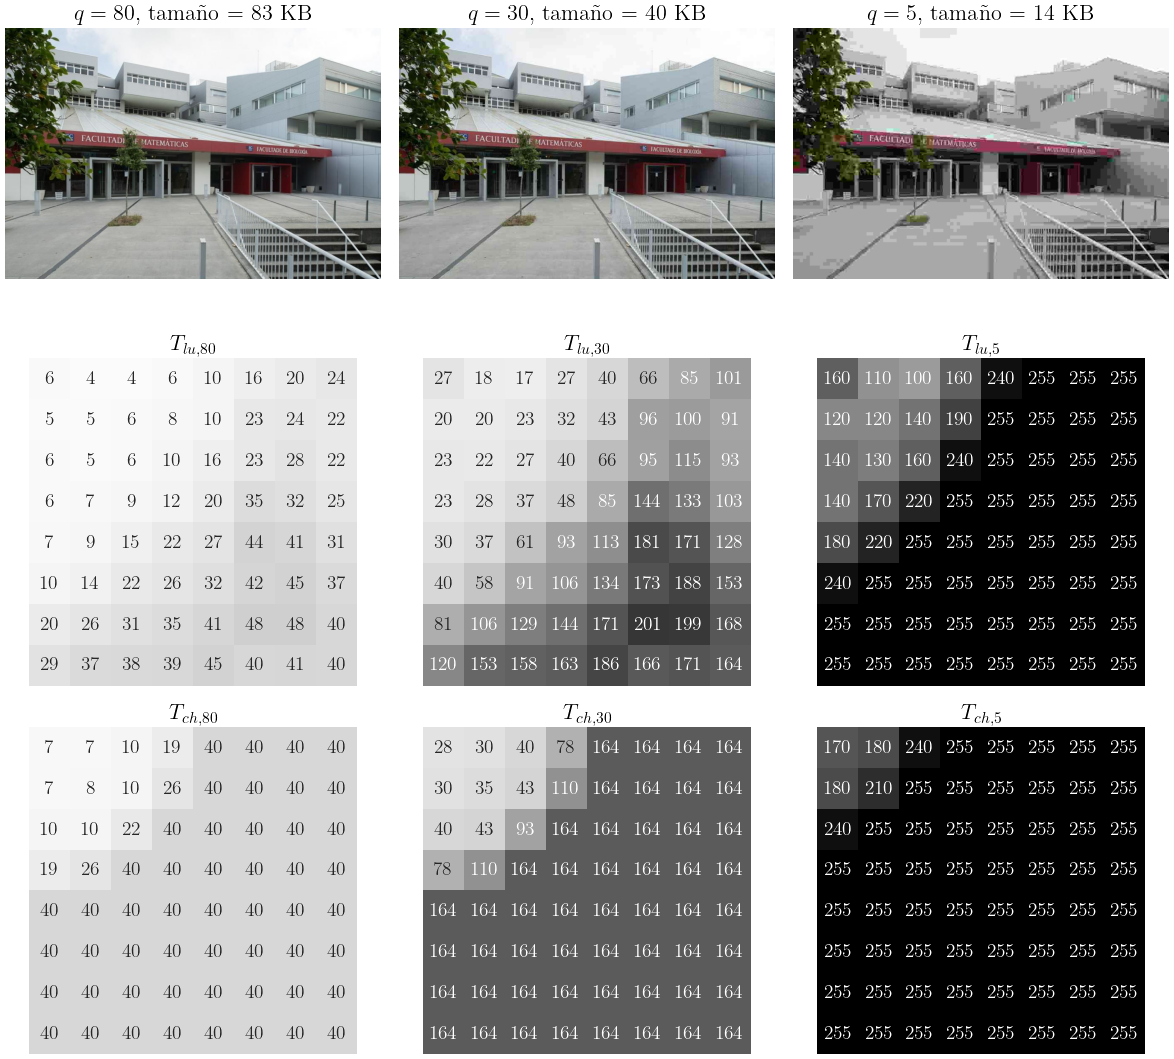

In [5]:
img_pil = Image.fromarray(img_rgb)

# Niveles de calidad
quality_levels = [80, 30, 5]

# Figura de comparación de calidades con imágenes y tablas
fig, axes = plt.subplots(3, len(quality_levels), figsize=(4*len(quality_levels), 11))

for i, q in enumerate(quality_levels):
    # Procesar y leer imagen en JPEG
    buf = io.BytesIO()
    img_pil.save(buf, format='JPEG', quality=q)
    buf.seek(0)
    img_jpeg = Image.open(buf)

    # Extraer tamaño y mostrar calidad´
    size_kb = len(buf.getbuffer()) / 1024
    axes[0, i].imshow(img_jpeg)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"$q = {q}$, tamaño = {int(size_kb)} KB", fontsize=16) 

    # Extraer tablas de cuantización del JPEG
    qtables = img_jpeg.quantization
    luma_qtable = np.array(qtables[0]).reshape(8, 8)
    chroma_qtable = np.array(qtables.get(1, luma_qtable)).reshape(8, 8)

    # Tabla luma
    sns.heatmap(luma_qtable, annot=True, fmt='d', cmap='gray_r', cbar=False,
                ax=axes[1, i], square=True, linewidths=0, linecolor='gray', annot_kws={"size": 14}, vmin=0, vmax=255)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"$T_{{lu,{q}}}$", fontsize=16) 

    # Tabla chroma
    sns.heatmap(chroma_qtable, annot=True, fmt='d', cmap='gray_r', cbar=False,
                ax=axes[2, i], square=True, linewidths=0, linecolor='gray', annot_kws={"size": 14}, vmin=0, vmax=255)
    axes[2, i].axis('off')
    axes[2, i].set_title(f"$T_{{ch,{q}}}$", fontsize=16) 
    
plt.tight_layout()
save_fig("jpeg_quality_comp")
plt.show()

In [6]:
# Función auxiliar para obtener la tabla de cuantización (Luma=0 o Chroma=1,2) de una imagen
# para un nivel de calidad y un canal especificos
def get_quant_table(quality, channel):
    img_pil = Image.fromarray(img_rgb)
    buf = io.BytesIO()
    img_pil.save(buf, format='JPEG', quality=quality)
    buf.seek(0)
    img_jpeg = Image.open(buf)
    qtables = img_jpeg.quantization
    if channel == 0:
        qtable = qtables[0]
    else:
        qtable = qtables.get(1, qtables[0])
        
    quant_table = np.array(qtable).reshape(8, 8)
    return quant_table

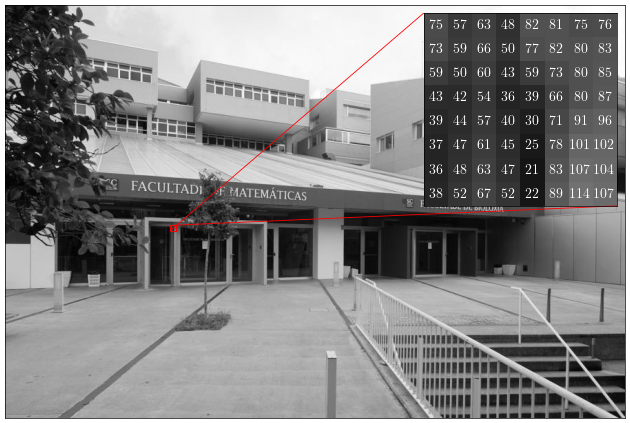

In [7]:
# Plot con un bloque resaltado sobre la imagen (canal Y)
CHANNEL = 0
BLOCK_I = 40
BLOCK_J = 30
block = get_block(img_ycc, CHANNEL, BLOCK_I, BLOCK_J)

plt.figure(figsize=(8, 6))
ax = plt.gca()
im = ax.imshow(img_ycc[:, :, CHANNEL], cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)  # disable grid
axins = zoomed_inset_axes(ax, zoom=35, loc='upper right')  # zoom factor 10, position upper right
x1, x2 = BLOCK_J*8, (BLOCK_J+1)*8
y1, y2 = BLOCK_I*8, (BLOCK_I+1)*8

axins.imshow(img_ycc[:, :, CHANNEL], cmap='gray')
# Add annotations (like heatmap)
for i in range(8):
    for j in range(8):
        val = block[i, j]
        axins.text(j + x1, i + y1, f"{val:.0f}", ha='center', va='center',
                   fontsize=10, color='white' if val < 128 else 'black')
# Adjust limits by 0.5 to align pixel edges properly
axins.set_xlim(x1 - 0.5, x2 - 0.5)
axins.set_ylim(y2 - 0.5, y1 - 0.5)  # inverted y-axis in image coords

axins.grid(False)
axins.set_xticks([])
axins.set_yticks([])
rect = plt.Rectangle((x1, y1), 8, 8, edgecolor='red', facecolor='none', linewidth=0.6)
ax.add_patch(rect)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="red", linewidth=0.6)
save_fig("block_extraction")
plt.show()

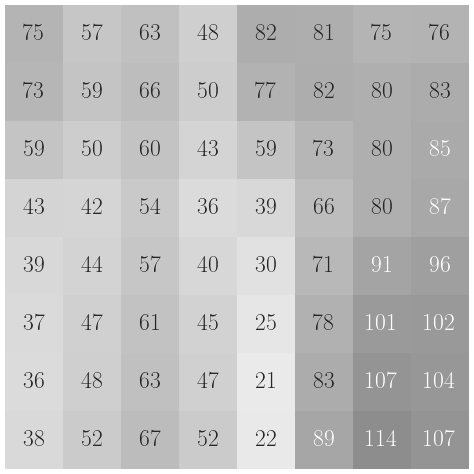

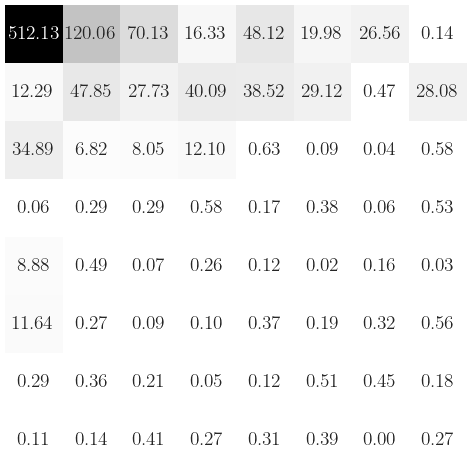

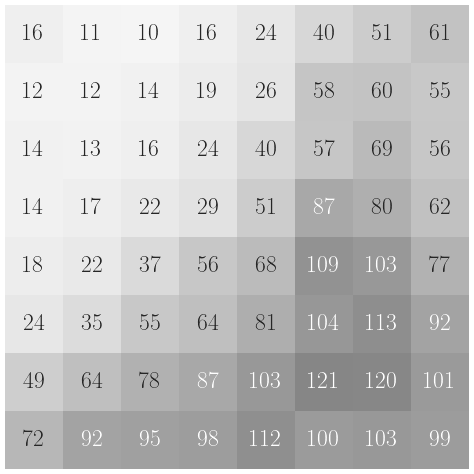

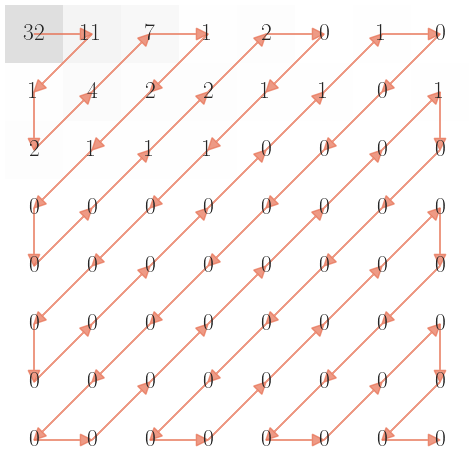

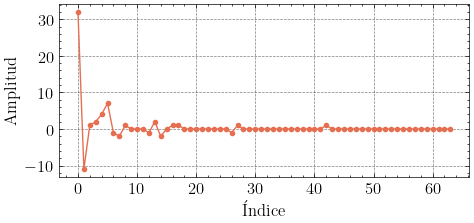

In [8]:
# 1. Bloque original
plt.figure(figsize=(5, 5))
sns.heatmap(block, annot=True, fmt=".0f", cmap="gray_r", cbar=False, vmin=0, vmax=255, annot_kws={"size": 17})
plt.axis('off')
plt.tight_layout()
save_fig("original_block")
plt.show()

# 2. Transformada del bloque
dct_block = dct2(block)
plt.figure(figsize=(5, 5))
sns.heatmap(np.abs(dct_block), annot=True, fmt=".2f", cmap="gray_r", cbar=False, annot_kws={"size": 14})
plt.axis('off')
plt.tight_layout()
save_fig("dct_block")
plt.show()

# 3. Tabla de cuantización
QUALITY = 50
quant_table = get_quant_table(QUALITY, CHANNEL)
plt.figure(figsize=(5, 5))
sns.heatmap(quant_table, annot=True, fmt=".0f", cmap="gray_r", cbar=False, vmin=0, vmax=255, annot_kws={"size": 17})
plt.axis('off')
plt.tight_layout()
save_fig("quant_table")
plt.show()

# 4. Bloque cuantizado con flechas zigzag
quant_block = quantize_block(dct_block, quant_table)
plt.figure(figsize=(5, 5))
ax = sns.heatmap(np.abs(quant_block), annot=True, fmt=".0f", cmap="gray_r", cbar=False, vmin=0, vmax=255, annot_kws={"size": 17})
plt.axis('off')

zigzag = zigzag_indices()
for idx in range(len(zigzag) - 1):
    y0, x0 = zigzag[idx]
    y1, x1 = zigzag[idx + 1]
    ax.arrow(x0 + 0.5, y0 + 0.5, x1 - x0, y1 - y0,
             head_width=0.2, head_length=0.2, fc='#e76f51', ec='#e76f51', 
             length_includes_head=True, alpha=0.7)
plt.tight_layout()
save_fig("quant_block")
plt.show()

# 5. Linearización del bloque
linearized_block = zigzag_block(quant_block)
plt.figure(figsize=(5, 2.5))
plt.plot(linearized_block, marker='.', color="#e76f51")
plt.xlabel("Índice")
plt.ylabel("Amplitud")
plt.grid(True)
plt.tight_layout()
save_fig("linearized_block")
plt.show()


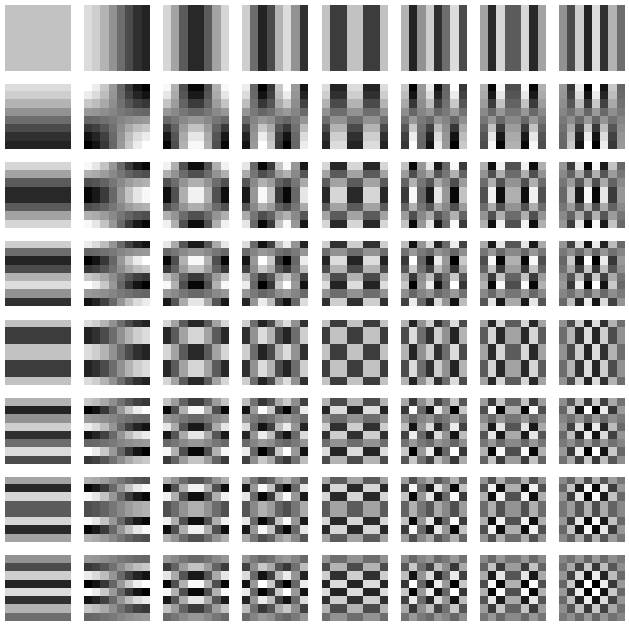

In [9]:
# Obtener funciones base de la DCT(8x8)
def dct_basis(u, v, N=8):
    x = np.arange(N)
    y = np.arange(N)
    X, Y = np.meshgrid(x, y)
    alpha_u = np.sqrt(1 / N) if u == 0 else np.sqrt(2 / N)
    alpha_v = np.sqrt(1 / N) if v == 0 else np.sqrt(2 / N)
    return alpha_u * alpha_v * np.cos(((2 * X + 1) * u * np.pi) / (2 * N)) * \
           np.cos(((2 * Y + 1) * v * np.pi) / (2 * N))

N = 8
basis_functions = np.zeros((N, N, N, N))
min_val = float('inf')
max_val = float('-inf')

# Normalizar cada una delas funciones base
for u in range(N):
    for v in range(N):
        basis = dct_basis(u, v)
        basis_functions[u, v] = basis
        min_val = min(min_val, np.min(basis))
        max_val = max(max_val, np.max(basis))

# Plot
fig, axes = plt.subplots(N, N, figsize=(8, 8))
for u in range(N):
    for v in range(N):
        ax = axes[u, v]
        ax.imshow(basis_functions[v, u], cmap='gray', vmin=min_val, vmax=max_val)
        ax.axis('off')
save_fig("dct2_basis")
plt.show()
